In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize, differential_evolution
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from tqdm import tqdm
from itertools import combinations

plt.style.use("ggplot")
np.set_printoptions(suppress=True) 

In [2]:
country = "US"
start = datetime.datetime(2021,12, 22)
end = datetime.datetime(2024, 1, 1)
min_return_per_year = 0.3 * ((end - start).days / 255)
plot_ = True

In [3]:
tickers_fr = (pd.read_html('https://fr.wikipedia.org/wiki/CAC_40')[2]["Mnémo"].apply(lambda x: x + ".PA")).to_list()
tickers_fr[tickers_fr.index("MT.PA")] = "MT.AS"
tickers_fr.remove("STLAP.PA")
tickers_sp = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]["Symbol"].to_list()
tickers_nq = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]["Symbol"].to_list()

if country == "US":
    tickers = set(tickers_sp + tickers_nq)
elif country == "FR":
    tickers = tickers_fr
else:
    tickers = set(tickers_sp + tickers_nq + tickers_fr)

In [4]:
df = yf.download(tickers, start, end)['Adj Close']
nan_per_ticker = df.isna().sum() != 0
tickers = [ticker for ticker in tickers if not nan_per_ticker[ticker]]
tickers = [ticker for ticker in tickers if (df[ticker].iloc[-1]-df[ticker].iloc[0])/df[ticker].iloc[0] > min_return_per_year]
df = df[tickers]
returns = df.pct_change().dropna()
correlation_matrix = returns.corr()

[*********************100%***********************]  519 of 519 completed

6 Failed downloads:
- GEV: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- AMTM: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- SOLV: Data doesn't exist for startDate = 1640149200, endDate = 1704085200
- SW: Data doesn't exist for startDate = 1640149200, endDate = 1704085200


In [5]:
def filter_stocks(correlation_matrix, corr_limit):
    mean_correlations = correlation_matrix.mean(axis=1)
    filtered_stocks = mean_correlations[mean_correlations < corr_limit].index
    return correlation_matrix.loc[filtered_stocks, filtered_stocks]

def find_low_correlation_combinations(correlation_matrix, number_of_stocks, corr_limit):
    filtered_matrix = filter_stocks(correlation_matrix, corr_limit)
    filtered_stocks = filtered_matrix.columns
    
    possible_combinations = list(combinations(filtered_stocks, number_of_stocks))
    
    less_correlated_stocks = []

    for combination in tqdm(possible_combinations, desc="Less Correlated Assets"):
        sub_matrix = correlation_matrix.loc[combination, combination]

        if (sub_matrix.values[~np.eye(len(sub_matrix), dtype=bool)] < corr_limit).all():
            less_correlated_stocks.append(combination)
    
    return less_correlated_stocks

In [6]:
number_of_stocks = 8
corr_limit = 0.37

less_correlated_stocks = find_low_correlation_combinations(correlation_matrix, number_of_stocks, corr_limit)

print("Number of Diversified Combinations:", len(less_correlated_stocks))

Less Correlated Assets: 100%|██████████| 24310/24310 [00:09<00:00, 2602.48it/s]

Number of Diversified Combinations: 28


In [7]:
tickers = list(less_correlated_stocks[0])
df = df[tickers]
n_assets = len(df.columns)
df

,STLD,DECK,SMCI,VLO,FSLR,PDD,CAH,LLY
Date,,,,,,,,
2021-12-22 00:00:00-05:00,58.612862,57.981667,4.259000,65.238579,87.919998,58.439999,46.414780,259.079163
2021-12-23 00:00:00-05:00,58.803623,59.421665,4.272000,65.632019,87.370003,57.709999,46.942009,265.495361
2021-12-27 00:00:00-05:00,59.843300,59.761665,4.476000,66.912994,87.860001,56.959999,47.506241,270.657501
2021-12-28 00:00:00-05:00,59.423615,59.838333,4.417000,68.166534,87.349998,56.040001,47.839226,268.732666
2021-12-29 00:00:00-05:00,59.490383,60.976665,4.555000,68.303764,87.180000,54.009998,48.144466,270.667267
...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,120.140594,115.614998,28.972000,129.439224,170.389999,144.479996,99.401154,567.629944
2023-12-26 00:00:00-05:00,119.558830,114.663330,29.433001,130.408569,171.940002,145.220001,99.214767,567.908569
2023-12-27 00:00:00-05:00,119.213707,114.626663,29.500000,129.067184,172.440002,144.449997,99.038200,578.696106


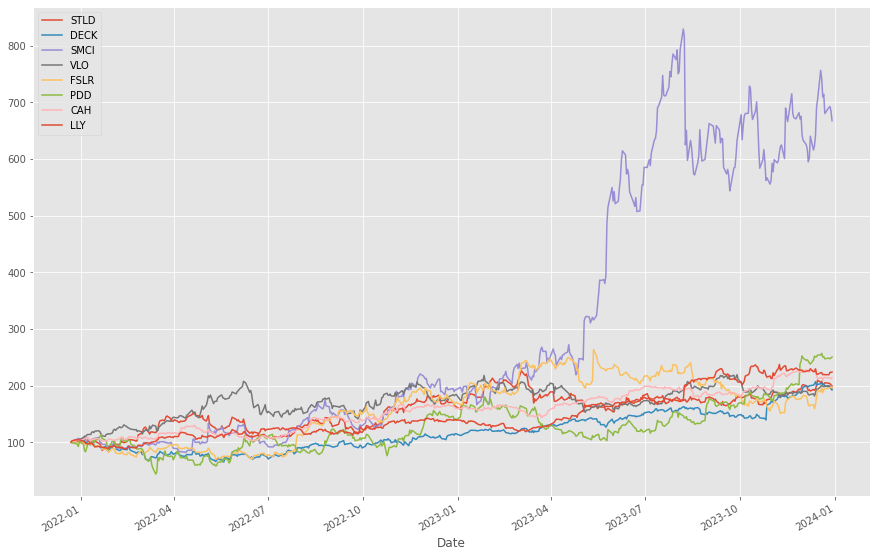

In [8]:
if plot_:
    (100 * df/df.iloc[0]).plot(figsize=(15, 10), legend=True)

# VaR

In [9]:
def calc_portfolio_perf_VaR(weights, returns, cov, alpha):
    portfolio_return = weights.T @ returns.mean() 
    portfolio_std = np.sqrt(weights.T @ cov @ weights)
    portfolio_var_histo = abs(np.percentile(returns @ weights.T, alpha*100))
    portfolio_var_param = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_var_histo, portfolio_var_param

def simulate_random_portfolios_VaR(num_portfolios, returns, cov, alpha, days):
    n_asset = len(returns.columns)
    results_matrix = np.ones((n_asset+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(n_asset)
        weights /= np.sum(weights)
        portfolio_return, portfolio_VaR_histo, portfolio_VaR_param  = calc_portfolio_perf_VaR(weights, returns, cov, alpha)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_VaR_histo
        results_matrix[2,i] = portfolio_VaR_param
        results_matrix[3:,i] *= weights
            
    results_df = pd.DataFrame(results_matrix.T,columns=['Return','VaR Histo','VaR Param'] + [ticker for ticker in tickers])
        
    return results_df

def obj_min_historical_var(weights, returns, alpha=0.05):
    portfolio_returns = np.dot(returns, weights)
    sorted_returns = np.sort(portfolio_returns)
    var_index = int(alpha * len(sorted_returns))
    var = abs(sorted_returns[var_index])
    return var

def obj_min_param_var(weights, returns, alpha=0.05):
    portfolio_mean = np.dot(weights, returns.mean())
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    var = abs(portfolio_mean - portfolio_std * stats.norm.ppf(1 - alpha))
    return var

def min_VaR(returns, cov, which):
    num_assets = len(returns.columns)
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.,1)
    bounds = tuple(bound for asset in range(num_assets))
    if which == "Parametric":
        result = minimize(obj_min_param_var, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    elif which == "Historical":
        result = minimize(obj_min_historical_var, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [10]:
returns = df.pct_change().dropna()
cov = returns.cov()
num_portfolios = 1000
days = 252
alpha = 0.05
sim_portfolio_VaR = simulate_random_portfolios_VaR(num_portfolios, returns, cov, alpha, days)
sim_portfolio_VaR

,Return,VaR Histo,VaR Param,STLD,DECK,SMCI,VLO,FSLR,PDD,CAH,LLY
0,0.002403,0.027932,0.030280,0.107336,0.285966,0.181913,0.047306,0.166898,0.109443,0.093901,0.007237
1,0.002014,0.021597,0.022047,0.161267,0.130466,0.088136,0.176467,0.094445,0.046484,0.195407,0.107329
2,0.002411,0.029296,0.031280,0.200112,0.172692,0.143315,0.196809,0.024337,0.205462,0.038231,0.019041
3,0.001775,0.022046,0.022943,0.188932,0.265425,0.018473,0.228185,0.020567,0.041798,0.140864,0.095755
4,0.002641,0.033060,0.036620,0.153133,0.119918,0.156835,0.022541,0.061678,0.320521,0.130929,0.034446
...,...,...,...,...,...,...,...,...,...,...,...
995,0.002426,0.026665,0.028732,0.208012,0.043477,0.179401,0.089096,0.206584,0.112158,0.087853,0.073418
996,0.002105,0.024461,0.026931,0.161490,0.166912,0.057165,0.148666,0.144100,0.156393,0.053721,0.111553
997,0.001897,0.020441,0.023456,0.157089,0.098340,0.015519,0.127884,0.206157,0.093170,0.138607,0.163235
998,0.002315,0.023634,0.025237,0.138663,0.131396,0.141689,0.093365,0.044061,0.140626,0.196605,0.113595


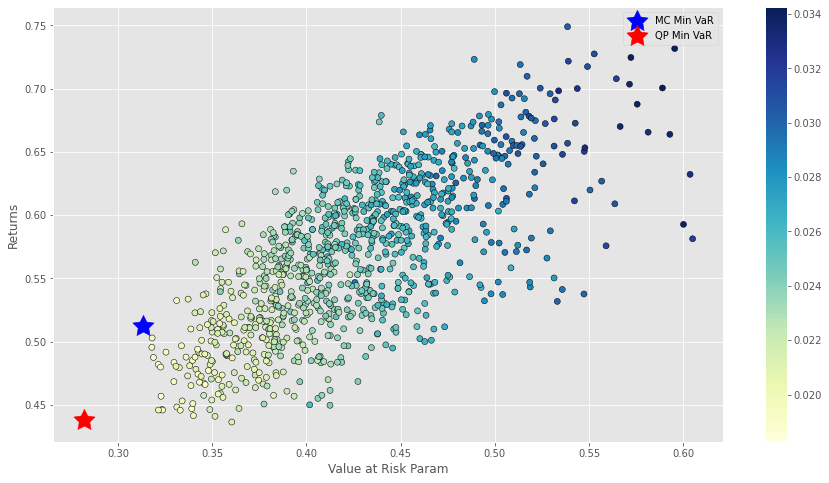

In [11]:
min_VaR_port_param_qp = min_VaR(returns, cov, "Parametric")
min_VaR_port_param = sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Param'].idxmin()]
plt.figure(figsize=(15, 8))
plt.scatter(sim_portfolio_VaR['VaR Param'] * np.sqrt(days), sim_portfolio_VaR['Return'] * days,c=sim_portfolio_VaR['VaR Histo'],edgecolors="black",cmap='YlGnBu')
plt.colorbar()
plt.scatter(min_VaR_port_param[2] * np.sqrt(days),min_VaR_port_param[0] * days,marker=(5,1,0),color='b',s=500, label="MC Min VaR")
plt.scatter(obj_min_param_var(min_VaR_port_param_qp * np.sqrt(days), returns, alpha=0.05), (min_VaR_port_param_qp @ returns.mean().T) * days, marker=(5,1,0), color='r', s=500, label="QP Min VaR")
plt.xlabel('Value at Risk Param')
plt.ylabel('Returns')
plt.legend()

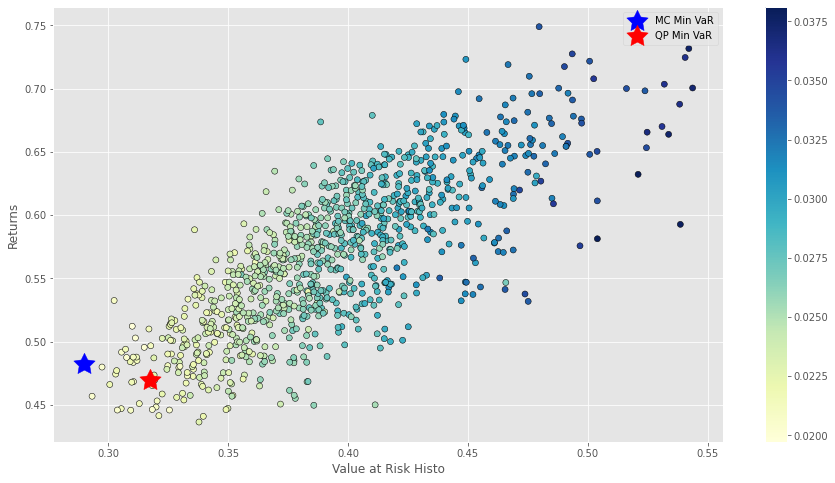

In [12]:
min_VaR_port_histo_qp = min_VaR(returns, cov, "Historical")
min_VaR_port_histo = sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Histo'].idxmin()]
plt.figure(figsize=(15, 8))
plt.scatter(sim_portfolio_VaR['VaR Histo'] * np.sqrt(days), sim_portfolio_VaR['Return'] * days,c=sim_portfolio_VaR['VaR Param'],edgecolors="black",cmap='YlGnBu')
plt.colorbar()
plt.scatter(min_VaR_port_histo[1] * np.sqrt(days), min_VaR_port_histo[0] * days,marker=(5,1,0),color='b',s=500, label="MC Min VaR")
plt.scatter(obj_min_historical_var(min_VaR_port_histo_qp, returns, alpha=0.05) * np.sqrt(days), (min_VaR_port_histo_qp @ returns.mean().T) * days, marker=(5,1,0), color='r', s=500, label="QP Min VaR")
plt.xlabel('Value at Risk Histo')
plt.ylabel('Returns')
plt.legend()

In [13]:
if country == "US":
    bench_ticker = "^GSPC"
elif country == "FR":
    bench_ticker = "^FCHI"
benchmark_returns = yf.download(bench_ticker, start, end)['Adj Close'].pct_change().dropna()
bench_port = 100 * (1 + benchmark_returns).cumprod()
equal_weigth_port = 100 * (1 + (returns @ np.ones(len(tickers))/len(tickers))).cumprod()
min_VaR_histo_port = 100 * (1 + (returns @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Histo'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_param_port = 100 * (1 + (returns @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Param'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_histo_port_qp_equity = 100 * (1 + (returns @ min_VaR_port_histo_qp.T)).cumprod()
min_VaR_param_port_qp_equity = 100 * (1 + (returns @ min_VaR_port_param_qp.T)).cumprod()

[*********************100%***********************]  1 of 1 completed


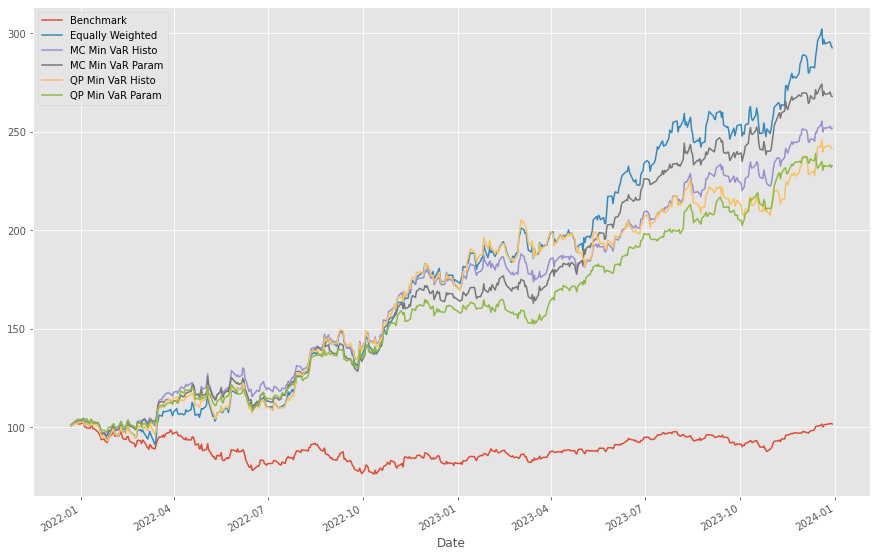

In [14]:
plt.figure(figsize=(15, 10))
bench_port.plot(label="Benchmark")
equal_weigth_port.plot(label="Equally Weighted")
min_VaR_histo_port.plot(label="MC Min VaR Histo")
min_VaR_param_port.plot(label="MC Min VaR Param")
min_VaR_histo_port_qp_equity.plot(label="QP Min VaR Histo")
min_VaR_param_port_qp_equity.plot(label="QP Min VaR Param")
plt.legend()

In [15]:
if country == "US":
    bench_ticker = "^GSPC"
elif country == "FR":
    bench_ticker = "^FCHI"
benchmark_returns_test = yf.download(bench_ticker, end)['Adj Close'].pct_change().dropna()
returns_test = yf.download(tickers, end)['Adj Close'].pct_change().dropna()
bench_port_test = 100 * (1 + benchmark_returns_test).cumprod()
equal_weigth_port_test = 100 * (1 + (returns_test @ np.ones(len(tickers))/len(tickers))).cumprod()
min_VaR_histo_port_test = 100 * (1 + (returns_test @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Histo'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_param_port_test = 100 * (1 + (returns_test @ sim_portfolio_VaR.iloc[sim_portfolio_VaR['VaR Param'].idxmin()].iloc[3:].T)).cumprod()
min_VaR_histo_port_qp_equity_test = 100 * (1 + (returns_test @ min_VaR_port_histo_qp.T)).cumprod()
min_VaR_param_port_qp_equity_tes = 100 * (1 + (returns_test @ min_VaR_port_param_qp.T)).cumprod()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  8 of 8 completed


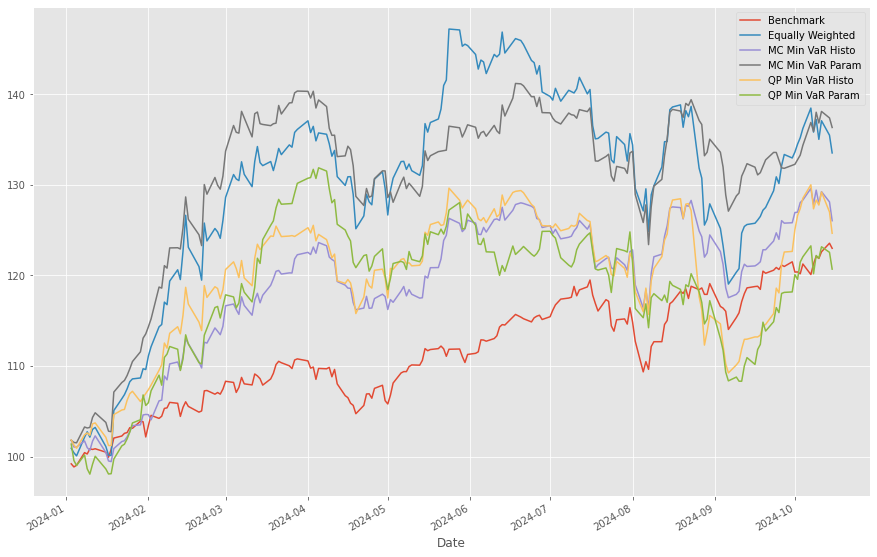

In [16]:
plt.figure(figsize=(15, 10))
bench_port_test.plot(label="Benchmark")
equal_weigth_port_test.plot(label="Equally Weighted")
min_VaR_histo_port_test.plot(label="MC Min VaR Histo")
min_VaR_param_port_test.plot(label="MC Min VaR Param")
min_VaR_histo_port_qp_equity_test.plot(label="QP Min VaR Histo")
min_VaR_param_port_qp_equity_tes.plot(label="QP Min VaR Param")
plt.legend()

# Mean-Variance / Sharpe Ratio Optimization

In [17]:
num_portfolios = 10000
days = 255
rf = 0.01

In [18]:
return_estimation_method = "Historical"
variance_estimation_method = "Historical"

### Monte Carlo version

In [19]:
def return_estimations(method, returns, days):
    if method == "Historical":
        returns_res = returns.mean()
    return returns_res * days

def cov_estimation(method, returns, days):
    if method == "Historical":
        cov_res = returns.cov()
    return cov_res * days

def simulate_random_portfolios_mean_variance(num_portfolios, returns, rf, method="Historical"):
    n_asset = len(returns.columns)
    results_matrix = np.ones((n_asset+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(n_asset)
        weights /= np.sum(weights)
        portfolio_return = (weights @ return_estimations(method, returns, days).T)
        portfolio_variance = (weights.T @ cov_estimation(method, returns, days) @ weights)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = np.sqrt(portfolio_variance)
        results_matrix[2,i] = (portfolio_return - rf) / portfolio_variance
        results_matrix[3:,i] *= weights
            
    results_df = pd.DataFrame(results_matrix.T,columns=['Return','Std', "Sharpe Ratio"] + [ticker for ticker in tickers])
        
    return results_df

In [20]:
df_sim_min_var = simulate_random_portfolios_mean_variance(num_portfolios, returns, rf, method="Historical")
df_sim_min_var

,Return,Std,Sharpe Ratio,STLD,DECK,SMCI,VLO,FSLR,PDD,CAH,LLY
0,0.644872,0.318483,6.259113,0.210739,0.170974,0.199311,0.108066,0.001409,0.167024,0.035605,0.106872
1,0.589048,0.276040,7.599225,0.063153,0.166077,0.135738,0.016750,0.163841,0.131950,0.169794,0.152697
2,0.594373,0.263307,8.428821,0.171845,0.085497,0.168768,0.132086,0.073474,0.090621,0.149104,0.128604
3,0.560897,0.282957,6.880634,0.148442,0.011676,0.059970,0.226984,0.002679,0.225447,0.117886,0.206916
4,0.583977,0.289931,6.828189,0.070143,0.077980,0.117024,0.170487,0.209204,0.158421,0.173832,0.022909
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.702306,0.361713,5.291391,0.019663,0.114593,0.221698,0.125704,0.121568,0.259154,0.058049,0.079573
9996,0.626862,0.310619,6.393392,0.192420,0.022549,0.171406,0.241406,0.105748,0.166791,0.060689,0.038991
9997,0.660314,0.329842,5.977385,0.038461,0.202828,0.194786,0.040489,0.101551,0.207432,0.103634,0.110819
9998,0.530367,0.289216,6.221084,0.095802,0.114577,0.018098,0.165149,0.153089,0.210916,0.031502,0.210869


### QP version

In [21]:
def obj_portfolio_return(w, mean_returns, cov):
    portfolio_return = w @ mean_returns.T
    return -portfolio_return

def obj_portfolio_std(w, mean_returns, cov):
    portfolio_std = np.sqrt(w.T @ cov @ w)
    return portfolio_std

def obj_sharpe_ratio(w, mean_returns, cov, rf):
    return -((w.T @ mean_returns) - rf)/ np.sqrt(w @ cov @ w.T)

def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.,1.)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(obj_portfolio_std, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def max_return(mean_returns, cov, target_risk):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                  {'type': 'eq', 'fun': lambda x: obj_portfolio_std(x, mean_returns, cov) - target_risk})
    bound = (0.,1.)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(obj_portfolio_return, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.,1)
    bounds = tuple(bound for asset in range(num_assets))
    result = minimize(obj_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [22]:
mean_returns = return_estimations(return_estimation_method, returns, days)
cov_returns = cov_estimation(variance_estimation_method, returns, days)
rf = 0.05
min_port_variance = min_variance(mean_returns, cov_returns)
max_sharpe_ratio_port = max_sharpe_ratio(mean_returns, cov_returns, rf)

efficient_frontier = []
max_var, min_var = max(df_sim_min_var['Std']), np.sqrt(min_port_variance.T @ cov_returns @ min_port_variance)
target_risks = np.linspace(min_var, max_var, 50)
efficient_frontier_weights = []
for i in tqdm(range(len(target_risks)), desc="Efficient Frontier Construction"):
    w_eff_fr = max_return(mean_returns, cov_returns, target_risks[i])
    efficient_frontier.append((target_risks[i], w_eff_fr @ mean_returns.T))
    efficient_frontier_weights.append(w_eff_fr)

Efficient Frontier Construction: 100%|██████████| 50/50 [00:00<00:00, 63.38it/s]


### Visualization

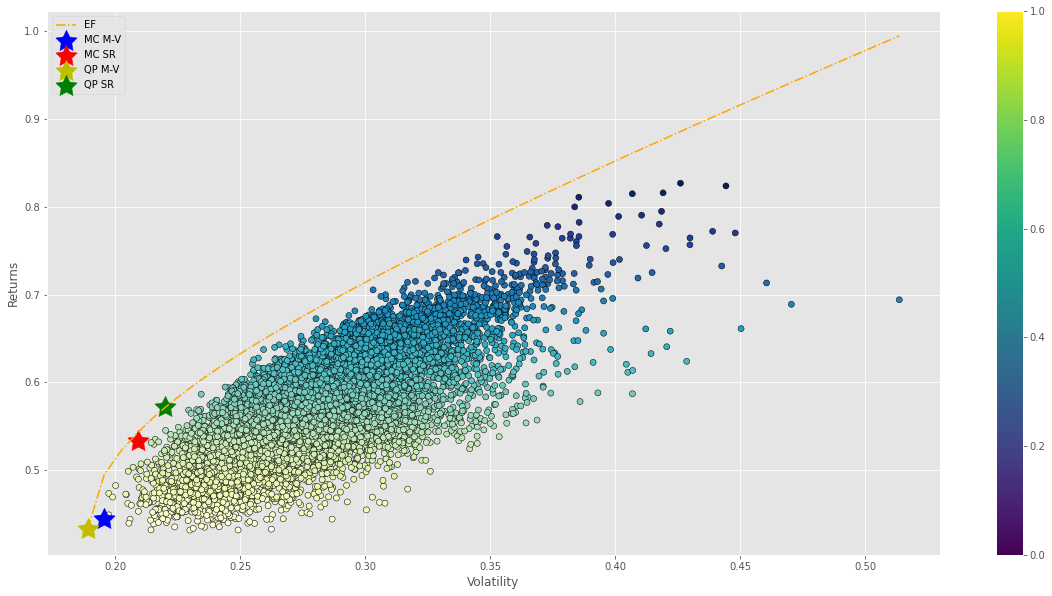

In [23]:
mean_variance_port_monte_carlo = df_sim_min_var.iloc[df_sim_min_var['Std'].idxmin()]
sharpe_ratio_port_monte_carlo = df_sim_min_var.iloc[df_sim_min_var['Sharpe Ratio'].idxmax()]
plt.figure(figsize=(20,10))
plt.plot([x[0] for x in efficient_frontier], [x[1] for x in efficient_frontier], color="orange", ls='-.', label="EF")
plt.scatter(df_sim_min_var.Std, df_sim_min_var.Return,c=df_sim_min_var.Return, edgecolors="black", cmap='YlGnBu')
plt.scatter(mean_variance_port_monte_carlo[1], mean_variance_port_monte_carlo[0], marker=(5,1,0), color='b',s=500, label="MC M-V")
plt.scatter(sharpe_ratio_port_monte_carlo[1], sharpe_ratio_port_monte_carlo[0], marker=(5,1,0), color='r',s=500, label="MC SR")
plt.scatter(np.sqrt(min_port_variance.T @ cov_returns @ min_port_variance), min_port_variance @ mean_returns.T, marker=(5,1,0), color='y', s=500, label="QP M-V")
plt.scatter(np.sqrt(max_sharpe_ratio_port.T @ cov_returns @ max_sharpe_ratio_port), max_sharpe_ratio_port @ mean_returns.T, marker=(5,1,0), color='g', s=500, label="QP SR")
plt.colorbar()
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.legend()

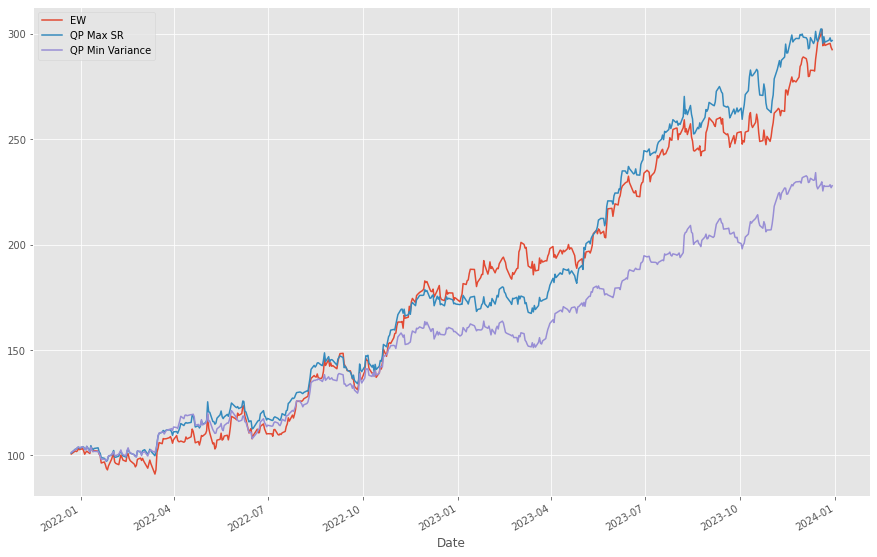

In [24]:
plt.figure(figsize=(15, 10))
(100 * (1 + returns @ (np.ones(n_assets)*1/n_assets).T).cumprod()).plot(label="EW")
(100 * (1 + returns @ max_sharpe_ratio_port.T).cumprod()).plot(label="QP Max SR")
(100 * (1 + returns @ min_port_variance.T).cumprod()).plot(label="QP Min Variance")
plt.legend()

## TEST

In [25]:
risk_grades = pd.DataFrame(np.round(efficient_frontier, 3), columns=["Volatility", "Return"])
risk_grades

,Volatility,Return
0,0.189,0.433
1,0.196,0.495
2,0.202,0.522
3,0.209,0.542
4,0.216,0.561
5,0.222,0.577
6,0.229,0.591
7,0.235,0.605
8,0.242,0.618
9,0.249,0.630


In [26]:
target_risk = risk_grades.iloc[5, 0]
target_risk

0.222

In [27]:
df_test = yf.download(tickers, end)['Adj Close']
returns_test = df_test.pct_change().dropna()
if country == "US":
    bench_ticker = "^GSPC"
elif country == "FR":
    bench_ticker = "^FCHI"
benchmark_returns = yf.download(bench_ticker, end)['Adj Close'].pct_change().dropna()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


In [28]:
returns_test = df_test.pct_change().dropna()

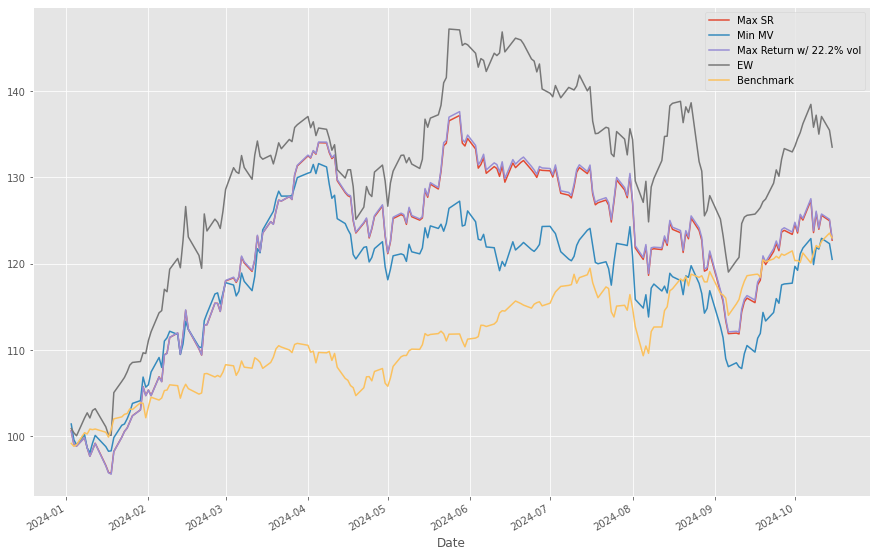

In [29]:
plt.figure(figsize=(15, 10))
(100 * (1 + returns_test @ max_sharpe_ratio_port.T).cumprod()).plot(label="Max SR")
(100 * (1 + returns_test @ min_port_variance.T).cumprod()).plot(label="Min MV")
(100 * (1 + returns_test @ efficient_frontier_weights[5].T).cumprod()).plot(label=f"Max Return w/ {round(target_risk*100, 3)}% vol")
(100 * (1 + returns_test @ (np.ones(n_assets)*1/n_assets).T).cumprod()).plot(label="EW")
(100 * (1 + benchmark_returns).cumprod()).plot(label="Benchmark")
plt.legend()